## Assignment 4 - Distributed Kalman Filtering

- **Topic:** Distributed state estimation of a target
- **Assessment:** The assignment will go through a pass/fail check.


- **Deadline:** 28-03-2025, 17:00
- **Submitting: SUBMIT ONLY `assignment4_groupNumber.ipynb` TO BRIGHTSPACE**. 
where groupNumber is your group number.



### Instructions
**Installation:** The implementation is tested with python 3.9.21 and packages including
-   numpy version: 2.0.2
-   matplotlib version: 3.9.4


Other (not too old or new) versions will probably also work.

You may not use other packages for algorithm-related calculations.
You only need to complete (and submit) this file.
Please do not change the additional files `helper.py` and `linAlg.py`, and the dictionary `model_parameters` as this might result in breaking the assignment.


### AI Related Policy
We strongly discourage you to use AI tools for implementation assistance. It is your understanding of the problem that is tested in the final exam.

### Personal Information
Please fill in your names and student numbers in the cell below.

In [2]:
# YOUR ANSWER HERE
STUDENT_1_NAME = "Niklas Knöll"
STUDENT_1_STUDENT_NUMBER = "5006961"

STUDENT_2_NAME = "Jefferson Yeh"
STUDENT_2_STUDENT_NUMBER = "5296005"

### Description and Objectives

The primary objective of this assignment is to estimate the position of a maneuvering target in 2D using a network of anchors. The target is traveling along an unknown trajectory in two dimensions, within the sensing range of the anchors, which have fixed positions. The anchors can measure the radial distance between themselves and the target throughout its journey, with some noise.

We consider a scenario similar to (but not identical to) the figure shown below. In the figure, a network of fixed-position anchors (blue circles) measures the radial distances (red circles) between themselves and the target (represented as a purple triangle). To estimate the target's position the anchors need to communicate with one another, however, they are only allowed to interact with their immediate neighbors in the network as indicated by the gray dashed lines.

The main focus will be to collaboratively estimate the target's position using distributed state estimation, by implementing a distributed Kalman filter formulation.
\
![alt text](multiagent_tracking.png "Title") 

Each anchor is denoted by an integer $n \in \{1, 2, \dots, N\}$ where $N$ is the number of anchors in the network. 
At each time step $k$, anchors measure the squared distance $(d_k^n)^2 \in \mathbb{R}^+$ between their (fixed) positions $\mathbf{p}^n \in \mathbb{R}^2$ and the target position $\mathbf{p}_k \in \mathbb{R}^2$ as
$$
    d_k^n \triangleq ||\mathbf{p}^n - \mathbf{p}_k ||_2.
$$
Unfortunately the measurement model is nonlinear and not suitable for a standard Kalman filter in this form.
We can however, tweak this formulation to obtain a linear form by squaring the distance and expanding the squared norm as
\begin{aligned}
    (d_k^n)^2 &=  ||\mathbf{p}^n - \mathbf{p}_k ||_2^2 = (\mathbf{p}^n - \mathbf{p}_k)^T (\mathbf{p}^n - \mathbf{p}_k), \\
              &= (\mathbf{p}^n)^T \mathbf{p}^n - 2 (\mathbf{p}^n)^T \mathbf{p}_k + \mathbf{p}_k^T \mathbf{p}_k, \\
    (d_k^n)^2 - (\mathbf{p}^n)^T \mathbf{p}^n &= - 2 (\mathbf{p}^n)^T \mathbf{p}_k + \mathbf{p}_k^T \mathbf{p}_k, \\
    y_k^n &= \tilde{\mathbf{H}}^n \tilde{\mathbf{p}}_k,
\end{aligned}
where $y_k^n \triangleq (d_k^n)^2 - ||\mathbf{p}^n||_2^2, \quad  \tilde{\mathbf{H}}^n \triangleq \begin{bmatrix}  - 2 (\mathbf{p}^n)^T  &  1 \end{bmatrix}, \quad  \tilde{\mathbf{p}}_k \triangleq  \begin{bmatrix} \mathbf{p}_k^T & ||\mathbf{p}_k||_2^2 \end{bmatrix}^T$.
Notice that we added $||\mathbf{p}_k||_2^2$ as a state variable to make this measurement model linear.

To use this approach, let us define the state vector of the target as 
$$ 
\mathbf{x}_k \triangleq \begin{bmatrix} \mathbf{p}_k^T & \dot{\mathbf{p}}_k^T &  ||\mathbf{p}_k||_2^2 \end{bmatrix}^T,
$$
where $ \dot{\mathbf{p}}_k \in \mathbb{R}^2 $ represents the velocity vector.
We can now formulate a state space model to use it for state estimation. 
Denote the state space equations as
\begin{aligned}
    \mathbf{x}_{k+1} &= \mathbf{F} \mathbf{x}_k + \mathbf{w}, \quad \mathbf{w} \sim \mathcal{N}(0, \mathbf{Q}), \\
    y_k^n &= \mathbf{H}^n \mathbf{x}_k + v, \quad v \sim \mathcal{N}(0, R),
\end{aligned}
where we choose the dynamic model matrix $\mathbf{F}$ and $\mathbf{H}^n$ as
\begin{aligned}
    \mathbf{F} &\triangleq \text{blkdiag} \biggl( \begin{bmatrix} 1 & \Delta t_k \\ 0 & 1 \end{bmatrix} \otimes \mathbb{I}_2, 1 \biggr), \\
    \mathbf{H}^n &\triangleq \begin{bmatrix}  - 2 (\mathbf{p}^n)^T & 0 & 0 & 1 \end{bmatrix}, \\
\end{aligned}
and $ \Delta t_k $ is the time difference between time step $k+1$ and $k$.

### Provided data
First let us load the simulated data, the data consists of the following elements
- `dt` $\in \mathbb{R}^+$ (float): Time difference between consecutive time steps
- `T` $\in \mathbb{N}$ (int): Number of time steps
- `edge_list` (list of tuples): Stores the edges as `(i,j)` which denotes the connection between anchors `i` and `j`.
- `anchor_positions` $\in \mathbb{R}^{2 \times N}$ (numpy array): Horizontally stacked anchor position vectors $[\mathbf{p}^1, \ \mathbf{p}^2, \ \dots, \mathbf{p}^N]$ 
- `measurement_list` $\in \mathbb{R}^{N \times T}$ (numpy array): List of measurements $y_k^n$ where `measurement_list[n, k]` denotes the measurement of anchor `n` at time step `k`.
- `true_positions` $\in \mathbb{R}^{2 \times T}$ (numpy array): Horizontally stacked true positions of the target $[\mathbf{p}_1, \ \mathbf{p}_2, \ \dots, \mathbf{p}_T]$ 

After we load the data, let us see what the anchor network, the ground truth trajectory and measurements look like. Note that the measurements plotted as two dimensional points just for clarity. Actual measurements look more like circles since we only measure the radial distances.

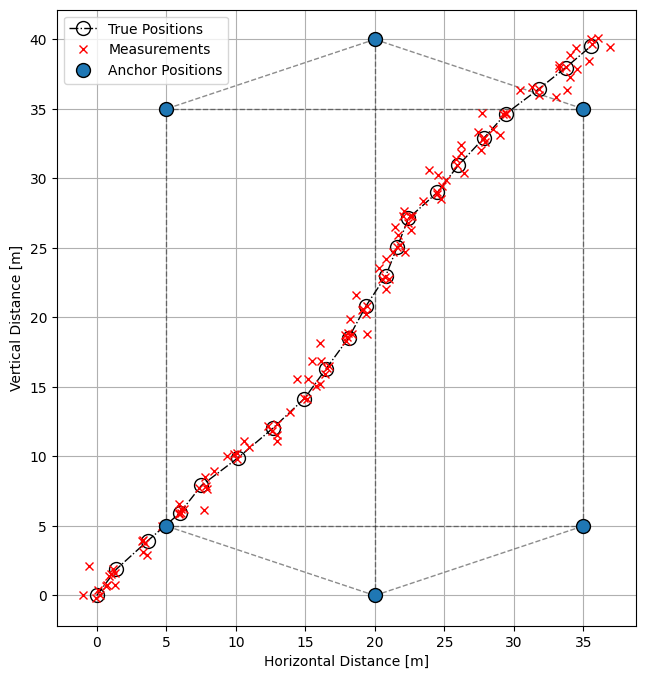

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from linAlg import block_diag
import helper as helper


plt.rcParams.update(
    {
        "lines.linewidth": 1.0,
        "lines.markersize": 10,
        "lines.markeredgewidth": 1.0
        
    }
)
measurement_list, true_states, anchor_positions, edge_list, dt, T, model_parameters = helper.initializeDKFAssignment()

helper.plotMeasurementsAndGroundTruth(true_states, anchor_positions, edge_list, model_parameters)


### Task 1: Construct Matrices
Construct dynamic model matrix $\mathbf{F}$ and measurement model matrices $\mathbf{H}^n$ as described above. 
You can use the parameters `initial_mean` vector,`initial_covariance` matrix, process covariance matrix `Q` and measurement noise variance `R` provided below for the rest of the assignment. 
You can use `block_diag` function to construct $\mathbf{F}$.


### Analysis:
Elaborate on the following:
- Why do we add the new variable $||\mathbf{p}_k||_2^2$ to the state vector? If we wanted to avoid doing this, how would you proceed?
    To enable us to make the observation model linear. Moving to a non-linear filter (such as EKF or UKF) would allow the usage of a simpler update model at the expense of a more complex filter.
- Comment on the dynamic update model of the state variable $||\mathbf{p}_k||_2^2$. Does it properly represent the true dynamics? If not, what can be done to mitigate its drawbacks? 
    It does not, the norm of the position vector should change together with the position vector, while in the dynamic model it does not. It would be possible to instead make the filter non-linear and use the velocity to update the norm of the position vector. 

In [4]:
#####  YOUR CODE HERE #####


topleftF= np.array([[1, 0, dt, 0],[0,1,0,dt], [0,0,1,0],[0,0,0,1]])
F = block_diag(topleftF, 1.0)
def ObsMatrix_H(anchor):
    return np.array([[-2*anchor[0], -2*anchor[1], 0,0,1]])


##### END HERE #####


# Initial Mean and covariance
initial_estimate = np.zeros((5,1))
initial_covariance = np.eye(initial_estimate.shape[0])*100.0

# Process noise covariance (Q) and Measurement noise covariance (R)
Q = np.diag([1.5, 0.15, 1.5, 0.15, 100.0])
R = 0.75


### Task 2: Centralized Kalman Filter Implementation
Implement a centralized version of the Kalman filter by using all measurements generated by the anchors to update the state estimate. After each time step, append your mean and covariance estimates to lists `centralized_means` and `centralized_covariances` respectively.

Note that for the centralized measurement update version you can use an augmented measurement model in the form
\begin{aligned}
    \begin{bmatrix} y_k^1 \\  y_k^2 \\ ... \\  y_k^N \end{bmatrix} &= \begin{bmatrix} \mathbf{H}^1 \\  \mathbf{H}^2 \\ ... \\  \mathbf{H}^N   \end{bmatrix}  \mathbf{x}_k + \mathbf{v}, \quad \mathbf{v} \sim \mathcal{N}(0, R \ \mathbb{I}_N).
\end{aligned}

### Analysis:
Elaborate on the following:
- Comment on the centralized Kalman filter mean estimates. Explain how $||\mathbf{p}_k||_2^2$ is estimated without even measuring the variable itself. 

$||\mathbf{p}_k||_2^2$ is not measured, but it is highly correlated to the the actual position $\mathbf{p}_k$, thus during the measurement update it is corrected towards it's true value as well.

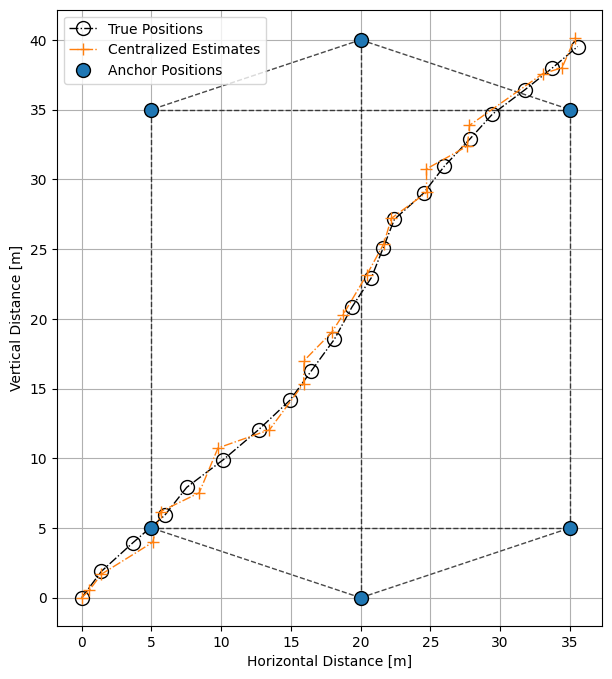

In [7]:
# Centralized estimates
centralized_means = [initial_estimate]
centralized_covariances = [initial_covariance]


#####  YOUR CODE HERE #####

#measurement model:
H_stacked = np.zeros((6,5))
for i, anchor in enumerate(anchor_positions.T):
    H_stacked[i,:] = ObsMatrix_H(anchor)



for i in range(measurement_list.shape[1]):
    #prediction
    theta_kmin1_kmin1 = centralized_means[i]
    sigma_kmin1_kmin1 = centralized_covariances[i]

    theta_k_kmin1 = F @ theta_kmin1_kmin1
    sigma_k_kmin1 = F @ sigma_kmin1_kmin1 @ F.T + Q

    # Correction:
    S_k = np.eye(6) * R + H_stacked @ sigma_k_kmin1 @ H_stacked.T
    K_k = sigma_k_kmin1 @ H_stacked.T @ np.linalg.inv(S_k)

    theta_k_k = theta_k_kmin1 + K_k @ (measurement_list[:,i].reshape((6,1)) - H_stacked @ theta_k_kmin1)
    sigma_k_k = sigma_k_kmin1 - K_k @ H_stacked @ sigma_k_kmin1

    centralized_means.append(theta_k_k)
    centralized_covariances.append(sigma_k_k)

##### END HERE #####


helper.plotCentralizedKFEstimate(true_states, anchor_positions, edge_list, centralized_means)

### Task 3: Distributed Kalman Filter Implementation
Implement a distributed Kalman filter using the formulation given below. After each time step, append your mean and covariance estimates for anchor `n` to lists `local_means[n]` and `centralized_covariances[n]` respectively.




Assume that anchor $n$ has access to measurements of itself and its neighbors $j \in \mathcal{N}_n \cup \{n\}$.
At time $k$, a local estimate can be computed using the following procedure:

\begin{aligned}
&\text{Time Update:} \\
&\hat{x}_{n, k+1 | k} = F \hat{x}_{n, k+1 | k}  \\
&P_{n, k+1 | k} = F P_{n, k+1 | k} F^T + Q  \\
\newline
&\text{Measurement Update:} \\
&x_{n,k} = \hat{x}_{n, k | k-1} \\
&P_{n,k} = P_{n, k | k-1} \\
&\text{For each} \ j \in \mathcal{N}_n \ \text{repeat:} \\
& \quad S_{j,k} = H_{j} P_{n,k} H_{j}^T + R_{j} \\
& \quad K_{j,k} = P_{n,k} H_{j}^T S_{j,k}^{-1} \\
& \quad x_{n,k} = x_{n,k} + K_{j,k} (y_{j,k} - H_{j} x_{n,k})\\
& \quad P_{n,k} = P_{n,k} - K_{j,k}  H_{j}  P_{n,k} \\
&\text{end} \\
&\hat{x}_{n, k | k} = x_{n,k} \\
&P_{n, k | k} = P_{n,k} \\
\end{aligned}

Alternatively a more compact from  can be expressed, similar to the information form KF, as
\begin{aligned}
&\text{Time Update:} \\
&\hat{x}_{n, k+1 | k} = F \hat{x}_{n, k | k}  \\
&P_{n, k+1 | k} = F P_{n, k | k} F^T + Q  \\
\newline
&\text{Measurement Update:} \\
&P_{n,k | k}^{-1} = P_{n,k | k-1}^{-1} + \sum_{j \in \mathcal{N}_n \cup \{n\}} H_{j}^T  R_{j}^{-1}  H_{j}  \\
&\hat{x}_{n, k | k} = \hat{x}_{n,k | k-1} + P_{n,k|k} \sum_{j \in \mathcal{N}_n \cup \{n\}} H_{j}^T R_{j}^{-1} (y_{j, k} - H_{j}\hat{x}_{n,k | k-1}  )\\
\end{aligned}

### Analysis:
Elaborate on the following:
- Analyze the behavior of the decentralized Kalman filter. At a glance, how does it differ from the centralized one?
- How would the estimates change if you change the number of edges. Comment on what would happen if all edges were removed.
- How many neighbors does an anchor need for a feasible solution? In other words, how many neighbors are required for each anchor to estimate a position? You may provide a geometric interpretation.

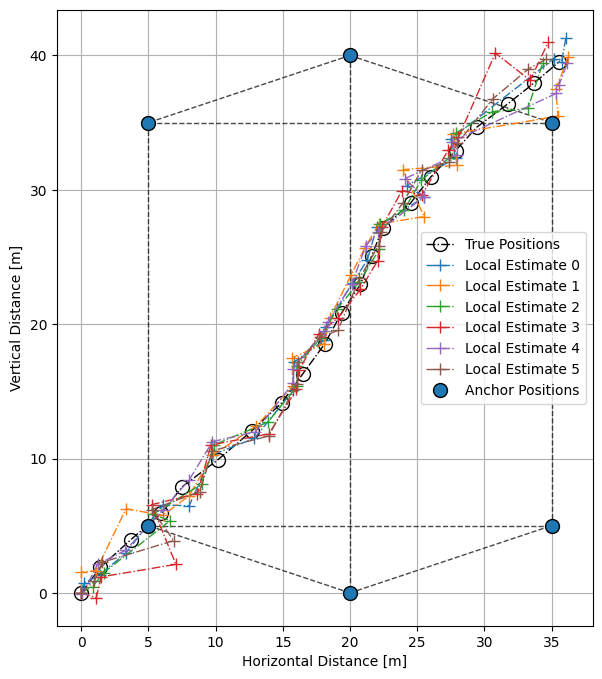

In [12]:
# Initialize anchor-specific variables
local_means = [[initial_estimate] for _ in range(anchor_positions.shape[1])]
local_covariances = [[initial_covariance] for _ in range(anchor_positions.shape[1])]


# local means: list containing 6 lists, each containing x for each anchor
#### YOUR CODE HERE ####

def get_available_measurements(anchor_number):
    points = set()
    for i, edge in enumerate(edge_list):
        if anchor_number in edge:
            points.add(edge[0])
            points.add(edge[1])
    return points

# for each timestep i
for i in range(measurement_list.shape[1]):
    
    # for each anchor j
    for n in range(anchor_positions.shape[1]):
        x_kmin1_kmin1 = local_means[n][i]
        sigma_kmin1_kmin1 = local_covariances[n][i]

        x_k_kmin1 = F @ x_kmin1_kmin1
        sigma_k_kmin1 = F @ sigma_kmin1_kmin1 @ F.T + Q

        
        x_n_k = x_k_kmin1
        P_n_k = sigma_k_kmin1
        # go through every available measurement j for that anchor
        for j in get_available_measurements(n):
            H = H_stacked[j,:].reshape((1,5))
            S = H @ sigma_k_kmin1 @ H.T + R
            K = sigma_k_kmin1 @ H.T @ np.linalg.inv(S)

            x_n_k += K @ (measurement_list[j,i] - H @ x_n_k)
            P_n_k -= K @ H @ P_n_k

        local_means[n].append(x_n_k)
        local_covariances[n].append(P_n_k)
        # x_k_kmin1 = [[F @ x_kmin1_local] for x_kmin1_local in x_kmin1_kmin1]


#### END HERE ####

helper.plotDecentralizedKFEstimate(true_states, anchor_positions, edge_list, local_means)



### Task 4: Comparison
Compute the squared errors of the centralized and local position mean estimates and plot them against time instances. Make sure that the axes are labeled with appropriate units. Also include a legend with descriptive names for each estimate.

### Analysis:
- Compare and discuss the filter performances. 
- What are the main advantages and disadvantages of centralized and decentralized Kalman filters?

In [ ]:
#### YOUR CODE HERE ####


#### END HERE ####

#### Feedback:
This is the first year we are teaching this course. Your feedback will be invaluable in improving it for the coming years. Please let us know in this markdown any comments, suggestions or errors you have encountered in the last three assignments.  